---
## Step 0: Load The Data

In [14]:
import os
import argparse
import json
import csv
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation
from keras.layers.convolutional import Convolution2D

import random

from os import listdir
from os.path import isfile, join

import numpy as np
from scipy import misc

import matplotlib.pyplot as plt

from PIL import Image
import cv2


In [15]:

def get_model(time_len=1):
  ch, row, col = 39, 160, 3 # camera format

  model = Sequential()
  model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(ch, row, col),
            output_shape=(ch, row, col)))
  model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
  model.add(ELU())
  model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
  model.add(ELU())
  model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
  model.add(Flatten())
  model.add(Dropout(.2))
  model.add(ELU())
  model.add(Dense(512))
  model.add(Dropout(.5))
  model.add(ELU())
  model.add(Dense(1))
#  model.add(Activation('tanh'))

  model.compile(optimizer="adam", loss="mse")

  return model

In [21]:
# center,left,right,steering,throttle,brake,speed
# IMG/center_2016_12_01_13_30_48_287.jpg,, IMG/left_2016_12_01_13_30_48_287.jpg,, IMG/right_2016_12_01_13_30_48_287.jpg,, 0,, 0,, 0,, 22.14829

X_train_center = []
X_train_left = []
X_train_right = []
Y_train_center = []
Y_train_left = []
Y_train_right = []
with open('../images/driving_log.csv', newline='') as csvfile:
    driving_reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(driving_reader, None)  # skip headers
    for row in driving_reader:
        angle = float(row[3].strip())
        speed = float(row[6].strip())
        if abs(speed) < 0.1 : 
            continue
        #balance the dataset. Ignore many of the zero angle cases
        if angle == 0:
            if random.randint(0,9) < 8:
                continue
        X_train_center.append(row[0])
        X_train_left.append(row[1])
        X_train_right.append(row[2])
        Y_train_center.append(angle)
        Y_train_left.append(max(angle + 0.25, -1))
        Y_train_right.append(min(angle - 0.25, 1))

print('Done!')


Done!


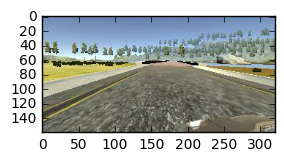

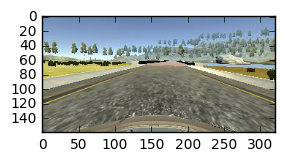

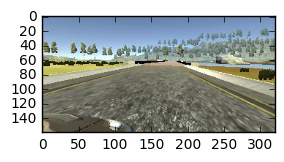

In [22]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.imshow(misc.imread("../images/"+X_train_left[20].strip()))
plt.figure(figsize=(3,3))
plt.imshow(misc.imread("../images/"+X_train_center[20].strip()))
plt.figure(figsize=(3,3))
plt.imshow(misc.imread("../images/"+X_train_right[20].strip()))

In [23]:
print('Start loading center images!')
X_train = []
for filename in X_train_center :
    X_train.append(misc.imread("../images/"+filename))

print('Start loading left images!')

for i in range(0, len(X_train_left)) :
    X_train.append(misc.imread("../images/"+X_train_left[i].strip()))
    #Y_train.append(Y_train[i])
    
print('Start loading right images!')

for i in range(0, len(X_train_right)) :
    X_train.append(misc.imread("../images/"+X_train_right[i].strip()))
    #Y_train.append(Y_train[i])
#print(X_train)
print('Loading images done!')

Start loading center images!
Start loading left images!
Start loading right images!
Loading images done!


In [24]:
Y_train = Y_train_center + Y_train_left + Y_train_right

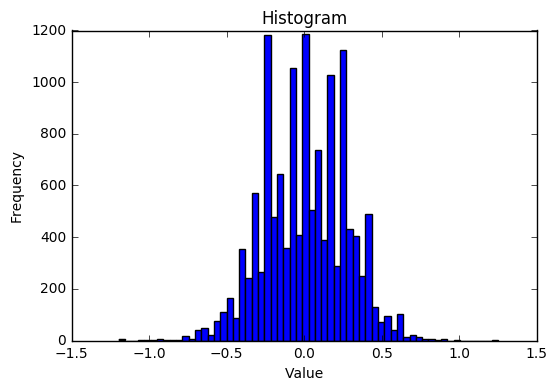

In [25]:
from numpy import array
import matplotlib.pyplot as plt
from numpy.random import normal

h = [float(x) for x in Y_train]
bins=np.histogram(h, bins=60)[1] #get the bin edges

plt.hist(h, bins=bins)
plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [26]:

def preprocess(data, y):
    
    #crop images
    for i in range(0, len(data)):
        data[i] = data[i][62:140, :]

    plt.imshow(data[1])
    #X_train[32].crop((0, 30, width, height-30))
    print("Cropped shape:")
    print(data[1].shape)
    
    #downsample images - fast way
    for i in range(0, len(data)):
        image = data[i]
        data[i] = image[::2,::2].copy()
        #print(int(width / 2.0))
        #X_train[i] = X_train[i].resize((60, 160), Image.ANTIALIAS)
        #X_train[i] = image

    #flip image
    for i in range(0, len(data)):
        data.append(cv2.flip(data[i], 1))
        y.append(-float(y[i]))
        
    plt.imshow(data[10])
    print("Downsampled shape:")
    print(data[1].shape)

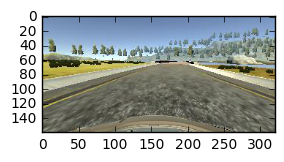

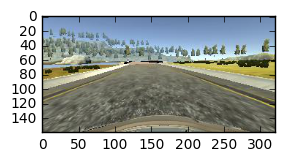

In [27]:
plt.figure(figsize=(3,3))
plt.imshow(X_train[10])
plt.figure(figsize=(3,3))
plt.imshow(cv2.flip(X_train[10], 1))

Preprocessing of images:
Old shape:
(160, 320, 3)
Cropped shape:
(78, 320, 3)
Downsampled shape:
(39, 160, 3)
Done!


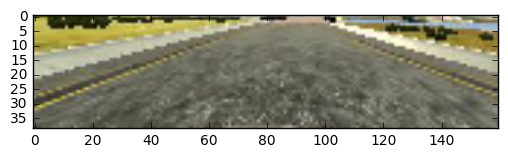

In [28]:
print("Preprocessing of images:")
print("Old shape:")
print(X_train[10].shape)

preprocess(X_train, Y_train)
print("Done!")

Start loading recovery images!
1371
Loading done!
Cropped shape:
(78, 320, 3)
Downsampled shape:
(39, 160, 3)
Preprocessing done!


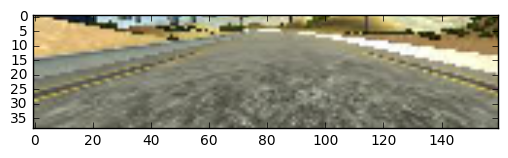

In [29]:
print('Start loading recovery images!')

X_train_recovery= []
Y_train_recovery= []
with open('../cloning/labels.csv', newline='') as csvfile:
#with open('tmp/data/track1_recovery/driving_log.csv', newline='') as csvfile:
    driving_reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in driving_reader:
        if len(row) == 0:
            continue
#        filename = 'tmp/data/'+row[0].replace('/home/patrick/Dev/SDCND/Term1/Lesson13 - Behavioral Cloning/data/','')
        filename = '../cloning/'+row[0]
        angle = float(row[1].strip())
        if os.path.isfile(filename) :
            X_train_recovery.append(misc.imread(filename))
            Y_train_recovery.append(angle)
            
len(X_train_recovery)
print(len(Y_train_recovery))
print('Loading done!')

preprocess(X_train_recovery, Y_train_recovery)
print('Preprocessing done!')


In [30]:
for img in X_train_recovery:
    X_train.append(img)
for angle in Y_train_recovery:
    Y_train.append(angle)

In [31]:
from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train)
X_train_recovery, Y_train_recovery = shuffle(X_train_recovery, Y_train_recovery)


from sklearn.cross_validation import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train,test_size=0.04)
#X_train_recovery,X_test_recovery,Y_train_recovery,Y_test_recovery = train_test_split(X_train_recovery,Y_train_recovery,test_size=0.2)



/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [32]:
X_train = np.array(X_train).astype(np.float)

In [33]:

Y_train = np.array(Y_train).astype(np.float)
X_test = np.array(X_test).astype(np.float)
Y_test = np.array(Y_test).astype(np.float)

In [34]:
print(len(X_test))
print(len(X_train))

1189
28517


In [38]:
batch_size = 150
epochs = 9

In [39]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(28517, 39, 160, 3)
(28517,)
(1189, 39, 160, 3)


In [40]:
model = get_model()
#model = model_from_json("model.json")
#model.load_weights('model.h5')

# Configures the learning process and metrics
model.compile(metrics=['mean_squared_error'], optimizer='Nadam', loss='mean_squared_error')

# Train the model
# History is a record of training loss and metrics
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=epochs, verbose=2, validation_data=(X_test, Y_test))

#history = model.fit(X_train, Y_train, batch_size=128, nb_epoch=2, validation_split=0.2)

# Calculate test score
# Save model architecture and weights
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

json_file.close()
model.save('model.h5')

# Show summary of model
model.summary()

Train on 28517 samples, validate on 1189 samples
Epoch 1/9
7s - loss: 0.1414 - mean_squared_error: 0.1414 - val_loss: 0.0592 - val_mean_squared_error: 0.0592
Epoch 2/9
7s - loss: 0.0292 - mean_squared_error: 0.0292 - val_loss: 0.0409 - val_mean_squared_error: 0.0409
Epoch 3/9
7s - loss: 0.0254 - mean_squared_error: 0.0254 - val_loss: 0.0241 - val_mean_squared_error: 0.0241
Epoch 4/9
7s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0241 - val_mean_squared_error: 0.0241
Epoch 5/9
7s - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.0524 - val_mean_squared_error: 0.0524
Epoch 6/9
7s - loss: 0.0212 - mean_squared_error: 0.0212 - val_loss: 0.0236 - val_mean_squared_error: 0.0236
Epoch 7/9
7s - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0239 - val_mean_squared_error: 0.0239
Epoch 8/9
7s - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0309 - val_mean_squared_error: 0.0309
Epoch 9/9
7s - loss: 0.0195 - mean_squared_error: 0.0195 - val_loss: 0.0200 - v